In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from pathlib import Path
import sys
from utils import *

# project root = parent of the notebooks/ folder
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from scipy.spatial.distance import cdist
from tqdm import tqdm
from config import Config, Config2
from template import LLAMA3_CHAT_TEMPLATE
from typing import Dict, Tuple
from peft import PeftModel
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from kmeans_pytorch import kmeans
import torch.nn.functional as F
import json
import re
import time

In [4]:
full_data_size = 2992

In [ ]:
cfg = Config()
model_id = cfg.model_id
print(model_id)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
tokenizer.pad_token = '<|finetune_right_pad_id|>'
model = AutoModelForCausalLM.from_pretrained(cfg.model_id, torch_dtype=torch.bfloat16, attn_implementation = 'flash_attention_2')
model = model.to('cuda')

In [ ]:
def make_template_format(df):
     df['question_f'] = df['question'].apply(lambda x : LLAMA3_CHAT_TEMPLATE.format(question = x))
     df['answer_f'] = df['answer'].apply(lambda x : x + tokenizer.eos_token)  
     return df

In [ ]:
def get_hidden_states_last_token(
    df, model, tokenizer, device, batch_size=1,
    max_length: int = 512
):
    """
    Returns a (N, H) array of penultimate-layer embeddings corresponding to the
    LAST non-padding token of each sequence.

    Args:
        df (pd.DataFrame): DataFrame with 'question_f' and 'answer_f' columns.
        model: The Hugging Face model.
        tokenizer: The Hugging Face tokenizer.
        device: The torch device ('cuda', 'cpu', etc.).
        batch_size (int): The batch size for processing.
        max_length (int): The maximum sequence length for the tokenizer.

    Returns:
        np.ndarray: A NumPy array of shape (N, H) where N is the number of
                    texts and H is the hidden size of the model.
    """
    # Combine question and answer to form the input text
    texts = (df['question_f'] + df['answer_f']).tolist()
    all_embeddings = []

    model.eval()
    print('Now extracting last-token hidden reps from the penultimate layer')

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors='pt',
            max_length=max_length
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Penultimate hidden states, shape: (B, T, H)
        # B = batch_size, T = sequence_length, H = hidden_size
        penultimate_hidden_states = outputs.hidden_states[-2]

        # Find the index of the last non-padding token for each sequence
        # The length of each sequence is the sum of its attention mask
        sequence_lengths = inputs['attention_mask'].sum(dim=1)
        
        # The index of the last token is the length - 1
        last_token_indices = sequence_lengths - 1

        # We need to select the hidden state at the `last_token_indices` for each
        # item in the batch. We can use advanced indexing for this.
        # Create a tensor of batch indices: [0, 1, 2, ...]
        batch_indices = torch.arange(len(penultimate_hidden_states), device=device)
        
        # Index the hidden states tensor to get the last token's representation
        # for each sequence in the batch.
        last_token_embeddings = penultimate_hidden_states[batch_indices, last_token_indices]
        
        # Move to CPU and convert to numpy array
        all_embeddings.append(last_token_embeddings.float().cpu().numpy())

    return np.vstack(all_embeddings)


def get_reps_last_token(df, model, tokenizer, device, batch_size=1, **kwargs):
    """
    Wrapper that returns a dataframe with a 'representation' column
    containing last-token embeddings.
    kwargs are passed to get_hidden_states_last_token.
    """
    embeddings = get_hidden_states_last_token(
        df=df, model=model, tokenizer=tokenizer, device=device,
        batch_size=batch_size, **kwargs
    )
    annotated_df = df.copy()
    # Store the numpy arrays as objects in the DataFrame column
    annotated_df['representation_lt'] = list(embeddings)
    return annotated_df

In [ ]:
df = pd.read_csv('./data/wpu_data/full_dataset_100.csv')

In [ ]:
df = make_template_format(df)
df = get_reps_last_token(df=df, model=model, tokenizer=tokenizer, device=torch.device('cuda'), batch_size=32)

In [6]:
titles = ['benedetto varchi', 'Benedetto Varchi', 'Wilhelm Wattenbach', 'wilhelm wattenbach']
f = df[df['title'].isin(titles) & (df['type'] == 'forget')]
f['cluster'].value_counts()

cluster
0    4
8    2
3    2
5    1
9    1
Name: count, dtype: int64

In [7]:
device = 'cuda'

In [ ]:
reps = np.vstack(df['representation_lt'].to_numpy())

In [8]:
start_time = time.time()
all_reps_tensor = torch.from_numpy(reps).to(dtype=torch.float64)
end_time = time.time()
print(f"Conversion to PyTorch tensor took: {end_time - start_time:.4f} seconds.")
print(f"Shape of PyTorch tensor: {all_reps_tensor.shape}")

Conversion to PyTorch tensor took: 0.0409 seconds.
Shape of PyTorch tensor: torch.Size([2302, 4096])


In [ ]:
torch.save(all_reps_tensor, 'reps_lt.pt')

In [ ]:
N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
initial_reps = np.vstack(df['representation_lt'].to_numpy())
df['cluster'] = kmeans.fit_predict(initial_reps)

print(f"Data clustered into {N_CLUSTERS} clusters.")
print("\n" + "="*50 + "\n")

In [12]:
def get_df(df, ret_path):
    ret = pd.read_csv(ret_path)
    df['type2'] = 'all'
    titles = ['benedetto varchi', 'Benedetto Varchi', 'Wilhelm Wattenbach', 'wilhelm wattenbach']
    f = df[df['title'].isin(titles) & (df['type'] == 'forget')]
    indices = f.index
    
    df['type2'] = df.index.map(lambda x: 'forget_1' if x in indices else 'other')

    keys = ["title", "question", "answer"]

    def norm(s): return s.fillna("").astype(str).str.strip().str.casefold()
    for c in keys:
        df[c]  = norm(df[c])
        ret[c] = norm(ret[c])

    m = pd.MultiIndex.from_frame(df[keys]).isin(pd.MultiIndex.from_frame(ret[keys]))
    if pd.api.types.is_categorical_dtype(df["type2"]):
        df["type2"] = df["type2"].cat.add_categories(["retain"])
    df.loc[m & df["type2"].ne("forget_1"), "type2"] = "retain"

    return df

### initial heuristics

In [13]:
def calculate_variance(reps, device=None, dtype=torch.float64):
    """
    reps: (n, d) array-like. Computes the mean pairwise cosine distance (same metric as sklearn).
    Uses GPU if available and `device` points to a CUDA device.
    Returns NaN for n < 2 (same idea as taking mean over empty upper triangle).
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    X = torch.as_tensor(reps, dtype=dtype, device=device)
    n = X.shape[0]
    if n < 2:
        return float("nan")
    Xn = F.normalize(X, p=2, dim=1)
    v = Xn.sum(dim=0)                
    sumsq = (Xn * Xn).sum()          
    sum_upper_sim = 0.5 * (v.dot(v) - sumsq)
    m = n * (n - 1) / 2.0
    mean_dist = 1.0 - (sum_upper_sim / m)
    return float(mean_dist.item())

def calculate_statistical_variance(reps, device='cuda', dtype=torch.float64):
    """
    Calculates the statistical variance of a set of representations.
    This is the PyTorch equivalent of np.variance.
    """
    if not isinstance(reps, torch.Tensor):
        X = torch.as_tensor(reps, dtype=dtype, device=device)
    else:
        X = reps.to(device=device, dtype=dtype)
        
    n = X.shape[0]
    if n < 2:
        return float("nan")

    # 1. Calculate the variance for each dimension across all samples.
    # The 'dim=0' argument computes variance along the rows (samples).
    variance_per_dimension = torch.var(X, dim=0)

    # 2. Calculate the mean of the variances across all dimensions
    # to get a single scalar value representing the overall variance.
    mean_variance = torch.mean(variance_per_dimension)

    return float(mean_variance.item())

In [14]:
def get_variance(df):
    df_ret = df[df['type2'] == 'retain']
    if not df_ret.empty:
        avg_div_ret = calculate_variance(np.vstack(df_ret['reps'].to_numpy()), device=device) 
    else:
        avg_div_ret = 0.0
    
    df_f = df[df['type2'] == 'forget_1']
    if not df_f.empty:
        avg_div_f = calculate_variance(np.vstack(df_f['reps'].to_numpy()), device=device)
    else:
        avg_div_f = 0.0

    df_o = df[df['type2'] == 'other']
    avg_div_o = calculate_variance(np.vstack(df_o['reps'].to_numpy()), device=device) if not df_o.empty else float('nan')
    avg_div_full = calculate_variance(np.vstack(df['reps'].to_numpy()), device=device) if not df.empty else float('nan')

    return avg_div_ret, avg_div_f, avg_div_o, avg_div_full

In [ ]:
def calculate_variance(reps, device='cuda', dtype=torch.float64):
    # Your original, correct calculate_variance function
    if not isinstance(reps, torch.Tensor):
        X = torch.as_tensor(reps, dtype=dtype, device=device)
    else:
        X = reps.to(device=device, dtype=dtype)
    n = X.shape[0]
    if n < 2: return float("nan")
    Xn = F.normalize(X, p=2, dim=1)
    v = Xn.sum(dim=0)
    sumsq = n
    sum_upper_sim = 0.5 * (v.dot(v) - sumsq)
    m = n * (n - 1) / 2.0
    mean_dist = 1.0 - (sum_upper_sim / m)
    return float(mean_dist.item())


def get_variance_from_tensor(df, all_reps_tensor, device='cuda'):
    """
    Calculates variance using a pre-computed tensor. This is extremely fast.
    """
    if df.empty:
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    all_reps_tensor_gpu = all_reps_tensor.to(device)
    is_retain = (df['type2'] == 'retain').values
    is_forget = (df['type2'] == 'forget_1').values
    is_other = (df['type2'] == 'other').values
    
    reps_ret = all_reps_tensor_gpu[is_retain]
    avg_div_ret = calculate_variance(reps_ret, device=device) if reps_ret.shape[0] > 0 else 0.0
    reps_f = all_reps_tensor_gpu[is_forget]
    avg_div_f = calculate_variance(reps_f, device=device) if reps_f.shape[0] > 0 else 0.0
    reps_o = all_reps_tensor_gpu[is_other]
    avg_div_o = calculate_variance(reps_o, device=device) if reps_o.shape[0] > 0 else float('nan')
    avg_div_full = calculate_variance(all_reps_tensor_gpu, device=device)
    return avg_div_ret, avg_div_f, avg_div_o, avg_div_full


def get_statistical_variance_from_tensor(df, all_reps_tensor, device='cuda'):
    """
    Calculates the mean statistical variance using a pre-computed tensor.
    This is the correct way to calculate variance similar to np.variance.
    """
    if df.empty:
        return float('nan'), float('nan'), float('nan'), float('nan')
    
    all_reps_tensor_gpu = all_reps_tensor.to(device)
    
    # Use boolean arrays from pandas for indexing, which is often cleaner
    is_retain = (df['type2'] == 'retain').values
    is_forget = (df['type2'] == 'forget_1').values
    is_other = (df['type2'] == 'other').values # Note: 'other' seems to be a new category in your code
    
    # --- Retain Set ---
    reps_ret = all_reps_tensor_gpu[is_retain]
    avg_var_ret = calculate_statistical_variance(reps_ret, device=device) if reps_ret.shape[0] > 0 else 0.0

    # --- Forget Set ---
    reps_f = all_reps_tensor_gpu[is_forget]
    avg_var_f = calculate_statistical_variance(reps_f, device=device) if reps_f.shape[0] > 0 else 0.0

    # --- Other Set ---
    reps_o = all_reps_tensor_gpu[is_other]
    avg_var_o = calculate_statistical_variance(reps_o, device=device) if reps_o.shape[0] > 0 else float('nan')

    # --- Full Set ---
    avg_var_full = calculate_statistical_variance(all_reps_tensor_gpu, device=device)
    
    return avg_var_ret, avg_var_f, avg_var_o, avg_var_full


In [18]:
def get_risk_map(df):
    cluster_totals = df['cluster'].value_counts()

    # Count forget samples in each cluster
    forget_df = df[df['type2'] == 'forget_1']
    forget_counts = forget_df['cluster'].value_counts()

    cluster_ratios_df = pd.DataFrame({
        'total_count': cluster_totals,
        'forget_count': forget_counts.reindex(cluster_totals.index).fillna(0)
    })

    # Calculate the final ratio for each cluster
    cluster_ratios_df['forget_ratio'] = cluster_ratios_df['forget_count'] / cluster_ratios_df['total_count']

    # This is your final risk map (as a Pandas Series for easy mapping)
    cluster_forget_ratios = cluster_ratios_df['forget_ratio']

    return cluster_forget_ratios

In [19]:
# --- Part 2: Define a function to calculate the score for any retain set ---
def calculate_contamination_score(retain_set_df, risk_map):
    """
    Calculates the contamination score for a given retain set.
    
    Args:
        retain_set_df (pd.DataFrame): DataFrame containing the samples of one retain set.
                                      Must have a 'cluster_label' column.
        risk_map (pd.Series): A Series mapping cluster_label to its forget_ratio.
    
    Returns:
        float: The contamination score for the retain set.
    """
    if retain_set_df.empty:
        return 0.0
    
    # For each sample in the retain set, find its cluster's forget_ratio
    # The .map() function is perfect for this lookup
    sample_risks = retain_set_df['cluster'].map(risk_map)
    
    # The final score is the average of these individual risks
    contamination_score = sample_risks.mean()
    
    return contamination_score

In [20]:
def contamination_score(df: pd.DataFrame):
    retain_cluster_df = df.loc[df['type2'] == 'retain']
    cluster_forget_ratios = get_risk_map(df)
    score = calculate_contamination_score(retain_cluster_df, cluster_forget_ratios)
    return score


In [21]:
def get_memories(df: pd.DataFrame):
    avg_mem = df['ori_mem'].mean()
    avg_ret_mem = df[df['type2'] == 'retain']['ori_mem'].mean()
    avg_f_mem = df[df['type2'] == 'forget_1']['ori_mem'].mean()
    avg_o_mem = df[df['type2'] == 'other']['ori_mem'].mean()
    return avg_mem, avg_ret_mem, avg_f_mem, avg_o_mem

def relative_utility_drop(new_utility: float, actual_utility: float = 0.92):
    return round(((actual_utility - new_utility) / actual_utility)*100, 2)

In [22]:

from typing import Dict, Any
def _safe_percent(vc: pd.Series, key: str) -> float:
    """Return normalized frequency for `key` or 0.0 if missing."""
    try:
        return float(vc.get(key, 0.0))
    except Exception:
        return 0.0

def _upsert_metrics_row(row: Dict[str, Any], csv_path: str, jsonl_path: str, key: str = 'ret_id') -> pd.DataFrame:
    """Upsert a single row into a CSV (by `key`), mirror to JSONL, and return the full DataFrame."""
    if os.path.exists(csv_path):
        log_df = pd.read_csv(csv_path)
    else:
        log_df = pd.DataFrame()

    # Ensure all columns from the new row exist in the current log
    for col in row.keys():
        if col not in log_df.columns:
            log_df[col] = pd.NA

    # Make sure we don't drop any pre-existing columns in the CSV
    # (fill missing values for new row with NA)
    for col in log_df.columns:
        if col not in row:
            row[col] = pd.NA

    # Upsert by key
    if key in log_df.columns and log_df.shape[0] > 0 and str(row[key]) in set(log_df[key].astype(str)):
        idx = log_df.index[log_df[key].astype(str) == str(row[key])][0]
        for k, v in row.items():
            log_df.at[idx, k] = v
    else:
        log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)

    # Save CSV
    log_df.to_csv(csv_path, index=False)

    # Mirror to JSONL by rewriting (avoids duplicates when updating)
    with open(jsonl_path, 'w', encoding='utf-8') as f:
        for rec in log_df.to_dict(orient='records'):
            f.write(json.dumps(rec) + "\n")

    return log_df

In [ ]:
LOG_CSV   = "unlearning_metrics_wpu.csv"
LOG_JSONL = "unlearning_metrics_wpu.jsonl"

In [24]:
def get_pre_unlearning_heursistics(df, all_reps_tensor, ret_path, ret_id, new_utility, data, fq:float, baseline_utility: float = 0.97):
    df['type2'] = 'all'
    df = get_df(df, ret_path)
    vc = df['type2'].value_counts(normalize=True)
    print(df['type2'].value_counts())

    forget_percent = _safe_percent(vc, 'forget_1')
    retain_percent = _safe_percent(vc, 'retain')

    
    ret_len   = int((df['type2'] == 'retain').sum())
    total_len = int(len(df))

    
    avg_var_ret, avg_var_f, avg_var_o, avg_var_full = get_statistical_variance_from_tensor(df, all_reps_tensor, device='cuda')
    cont_score = contamination_score(df) 
    avg_mem, avg_ret_mem, avg_f_mem, avg_o_mem = get_memories(df)
    rel_utility_drop = relative_utility_drop(new_utility, actual_utility=baseline_utility)

    
    row = {
        "dataset" : data,
        "ret_id": ret_id,
        "new_utility": float(new_utility),
        "baseline_utility": float(baseline_utility),
        "forget_percent": float(forget_percent),
        "retain_percent": float(retain_percent),
        "ret_len": ret_len,
        "total_len": total_len,
        "avg_var_ret": float(avg_var_ret),
        "avg_var_f": float(avg_var_f),
        "avg_var_o": float(avg_var_o),
        "avg_var_full": float(avg_var_full),
        "contamination_score": float(cont_score),
        "avg_mem": float(avg_mem),
        "avg_ret_mem": float(avg_ret_mem),
        "avg_f_mem": float(avg_f_mem),
        "avg_o_mem": float(avg_o_mem),
        "relative_utility_drop": float(rel_utility_drop),
        "fq" : float(fq),
        #"timestamp": pd.Timestamp.now().isoformat(timespec="seconds"),
    }

    
    log_df = _upsert_metrics_row(row, csv_path=LOG_CSV, jsonl_path=LOG_JSONL, key="ret_id")
    return row, log_df




In [25]:
def get_metrics_df(csv_path: str = LOG_CSV) -> pd.DataFrame:
    """Convenience: load the whole metrics log as a DataFrame for analysis."""
    if not os.path.exists(csv_path):
        return pd.DataFrame()
    return pd.read_csv(csv_path)

In [ ]:
all_reps_tensor = torch.load('reps_lt.pt')

/home/praveen/tmp/ipykernel_2805128/3501820782.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_reps_tensor = torch.load('/home/praveen/coreset/reps/reps/wpu/reps_lt.

In [ ]:
row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/grand_diff_top_20.csv", 
                                             ret_id="diff_20", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.79)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/grand_diff_top_10.csv", 
                                             ret_id="diff_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.63)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/grand_diff_top_5.csv", 
                                             ret_id="diff_5", data = "wpu",
                                             fq = 0.97,
                                             new_utility=0.39)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_20.csv", 
                                             ret_id="desc_20", data = "wpu",
                                             fq = 0.93,
                                             new_utility=0.66)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_10.csv", 
                                             ret_id="desc_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.46)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_5.csv", 
                                             ret_id="desc_5", data = "wpu",
                                             fq = 0.96,
                                             new_utility=0.21)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_5.csv", 
                                             ret_id="mod_5", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.27)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_10.csv", 
                                             ret_id="mod_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.58)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_20.csv", 
                                             ret_id="mod_20", data = "wpu",
                                             fq = 0.96,
                                             new_utility=0.73)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_5.csv", 
                                             ret_id="random_5", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.35)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_10.csv", 
                                             ret_id="random_10", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.36)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_20.csv", 
                                             ret_id="random_20", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.56)





/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):


type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64


/home/praveen/tmp/ipykernel_2805128/1815351367.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning:

type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64
type2
other       2178
retain       114
forget_1      10
Name: count, dtype: int64
type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64
type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64
type2
other       2178
retain       114
forget_1      10
Name: count, dtype: int64
type2
other       2180
retain       112
forget_1      10
Name: count, dtype: int64
type2
other       2065
retain       227
forget_1      10
Name: count, dtype: int64
type2
other       1836
retain       456
forget_1      10
Name: count, dtype: int64
type2
other       2177
retain       115
forget_1      10
Name: count, dtype: int64
type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64
type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64


/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_2805128/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

In [ ]:
metrics = get_metrics_df()

In [35]:
metrics['ret_id'].unique()

array(['diff_20', 'diff_10', 'diff_5', 'desc_20', 'desc_10', 'desc_5',
       'mod_5', 'mod_10', 'mod_20', 'random_5', 'random_10', 'random_20'],
      dtype=object)

### images

In [4]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
metrics = pd.read_csv('unlearning_metrics_wpu.csv')

In [6]:
print("--- DataFrame Shape ---")
print(f"The metrics DataFrame has {metrics.shape[0]} rows and {metrics.shape[1]} columns.\n")

# Check for the number of unique values in each column
print("--- Unique Value Counts ---")
print(f"Unique values in 'relative_utility_drop': {metrics['relative_utility_drop'].nunique()}")
print(f"Unique values in 'avg_var_o': {metrics['avg_var_o'].nunique()}\n")


# A very powerful way to check is with .describe()
print("--- Descriptive Statistics ---")
print(metrics[["relative_utility_drop", "avg_var_o"]].describe())

--- DataFrame Shape ---
The metrics DataFrame has 12 rows and 19 columns.

--- Unique Value Counts ---
Unique values in 'relative_utility_drop': 12
Unique values in 'avg_var_o': 12

--- Descriptive Statistics ---
       relative_utility_drop  avg_var_o
count               12.00000  12.000000
mean                48.54000   0.081143
std                 19.21815   0.001170
min                 18.56000   0.078356
25%                 34.27750   0.080868
50%                 47.42500   0.081461
75%                 63.14750   0.081871
max                 78.35000   0.082558


In [7]:
cols_to_correlate = metrics.columns.drop(['dataset', 'ret_id', 'baseline_utility', 'forget_percent', 'total_len', 'avg_var_full', 'avg_var_f', 'avg_mem','avg_f_mem', 'ret_len',  'new_utility', 'avg_ret_mem', 'avg_o_mem'])

# Initialize matrices for Pearson correlations and p-values
pearson_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                   index=cols_to_correlate, columns=cols_to_correlate)
pearson_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                index=cols_to_correlate, columns=cols_to_correlate)

# Initialize matrices for Spearman correlations and p-values
spearman_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                    index=cols_to_correlate, columns=cols_to_correlate)
spearman_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                 index=cols_to_correlate, columns=cols_to_correlate)

# Calculate correlations and p-values
for col1 in cols_to_correlate:
    for col2 in cols_to_correlate:
        # Pearson
        pearson_corr, pearson_p = pearsonr(metrics[col1], metrics[col2])
        pearson_corr_matrix.loc[col1, col2] = pearson_corr
        pearson_p_matrix.loc[col1, col2] = pearson_p
        
        # Spearman
        spearman_corr, spearman_p = spearmanr(metrics[col1], metrics[col2])
        spearman_corr_matrix.loc[col1, col2] = spearman_corr
        spearman_p_matrix.loc[col1, col2] = spearman_p

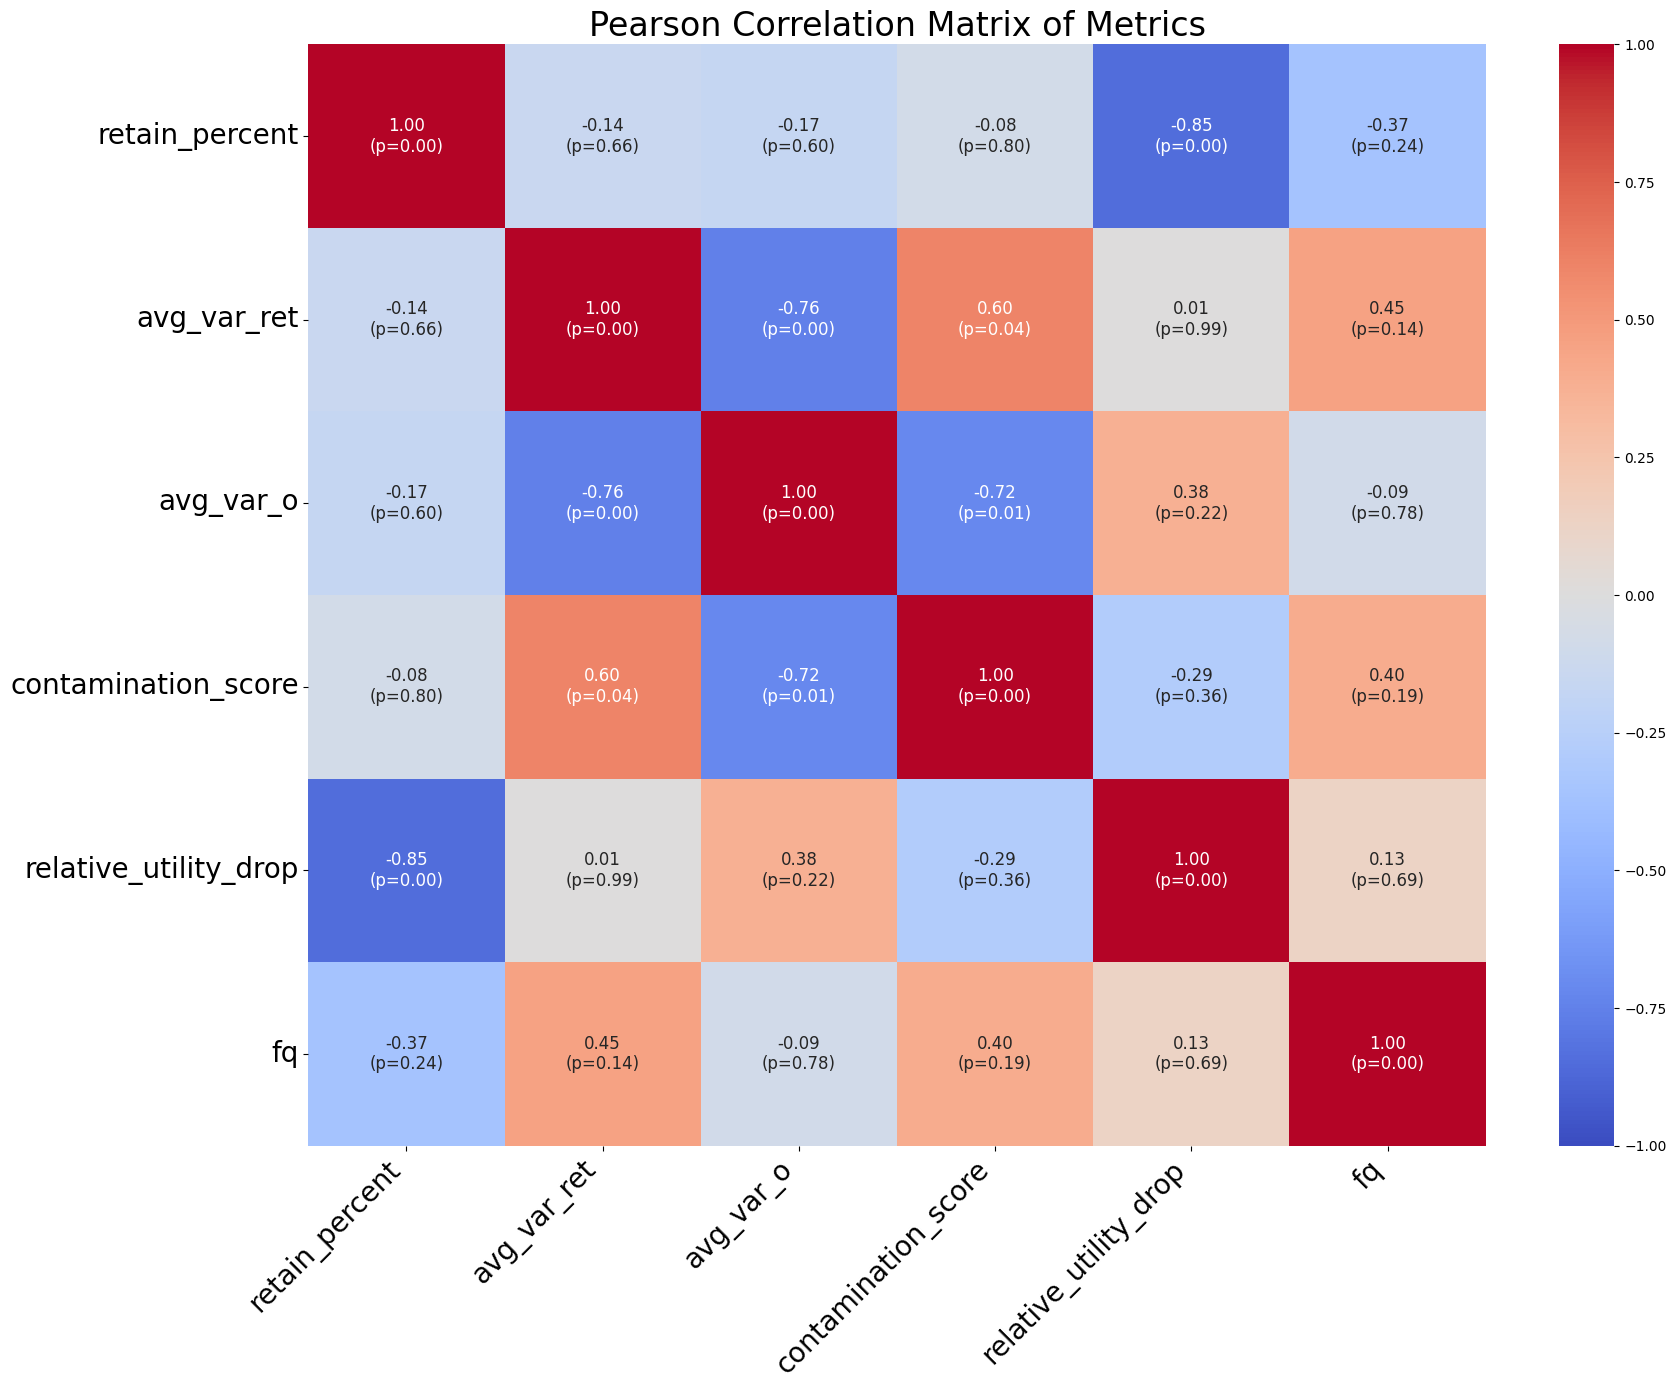

In [ ]:
pearson_annot = pearson_corr_matrix.map('{:.2f}'.format) + '\n(p=' + pearson_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(pearson_corr_matrix, annot=pearson_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 12})
plt.title('Pearson Correlation Matrix of Metrics', fontsize=24)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(rotation=0, fontsize = 20)
plt.tight_layout()
plt.savefig('./images/pearson_wpu_without_semsyn.pdf', bbox_inches='tight')
plt.show()

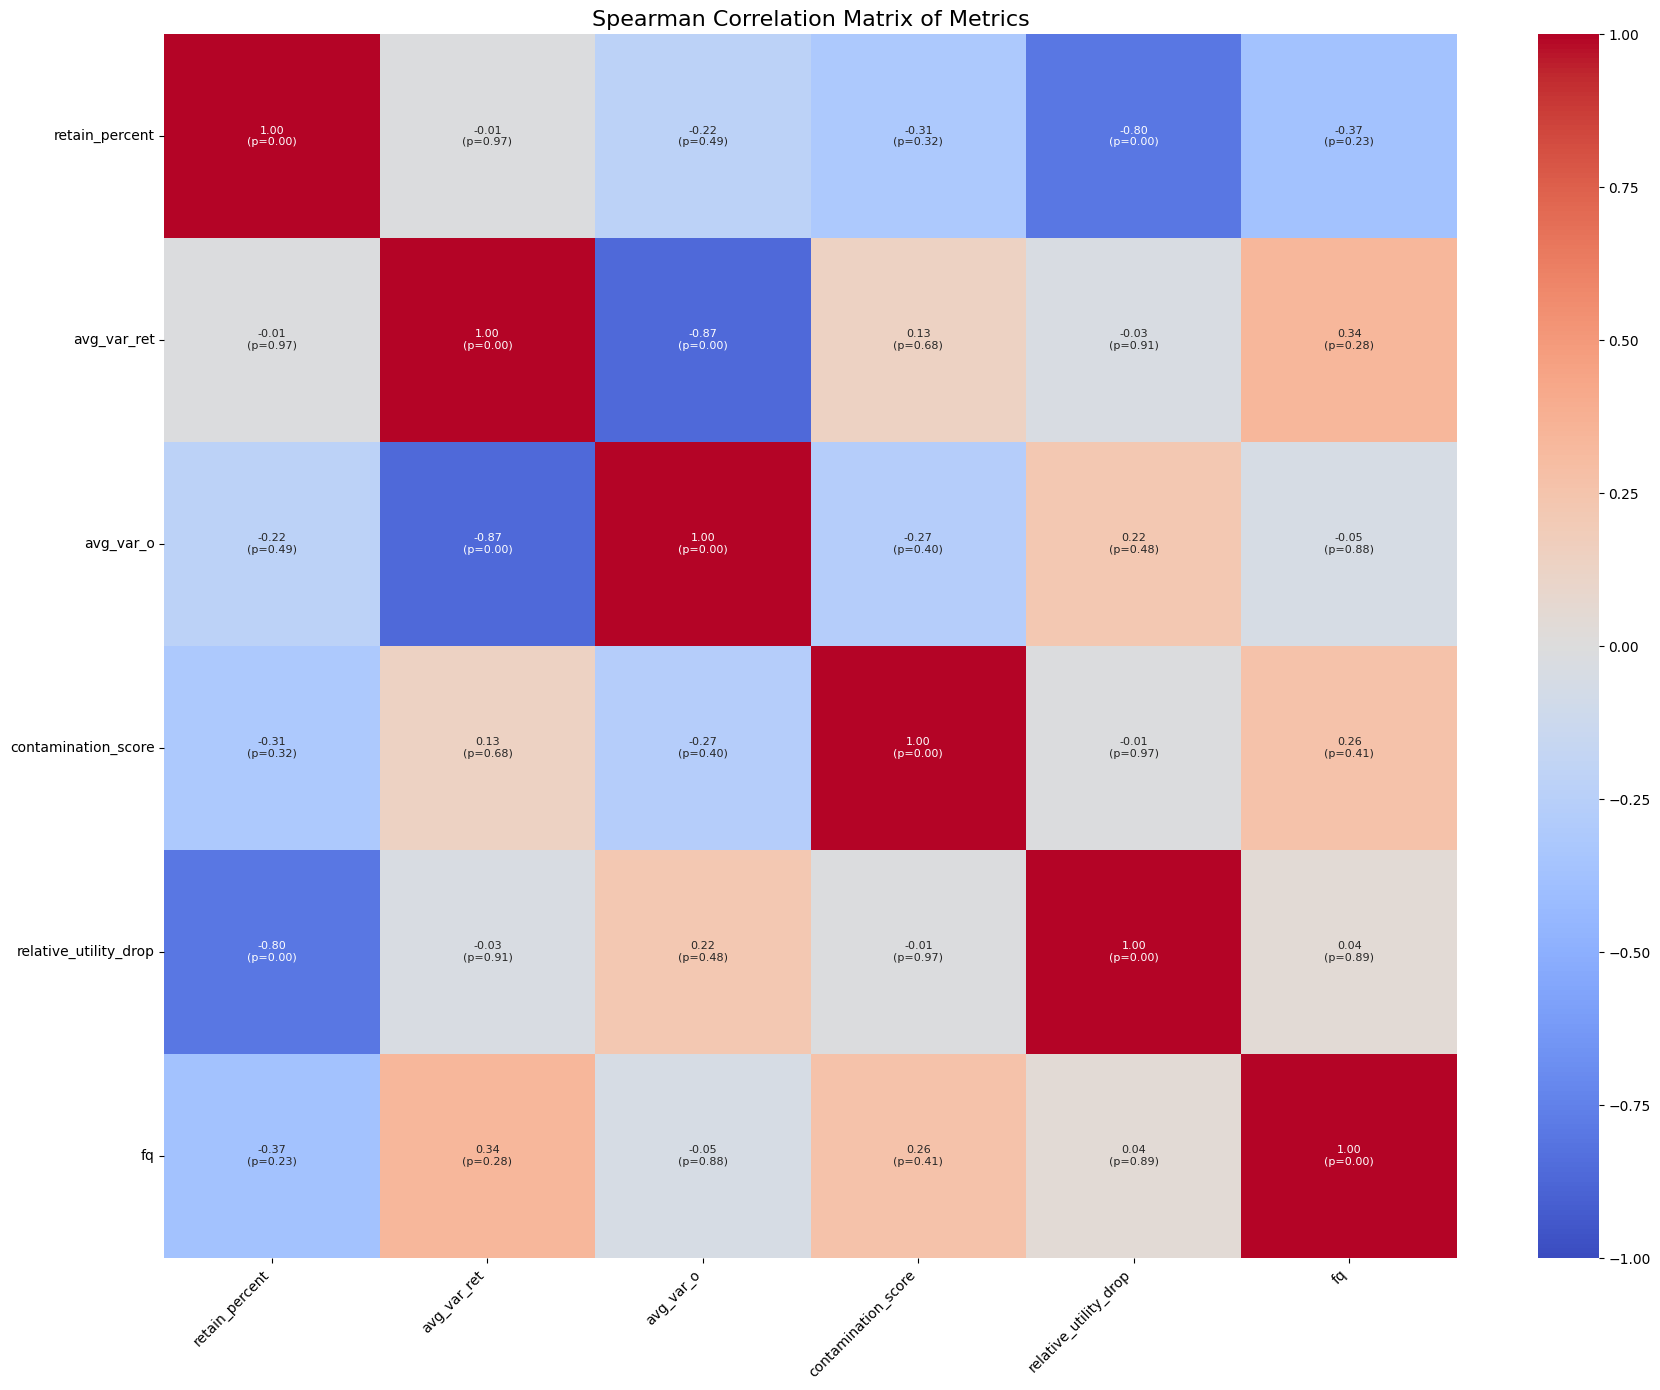

In [ ]:
spearman_annot = spearman_corr_matrix.map('{:.2f}'.format) + '\n(p=' + spearman_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(spearman_corr_matrix, annot=spearman_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Spearman Correlation Matrix of Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/spearman_wpu_without_semsyn.pdf', bbox_inches='tight')
plt.show()

In [40]:
target_var = 'relative_utility_drop'

# Get the list of features to correlate with the target
features = cols_to_correlate.drop(target_var)

# Extract the correlation and p-values for the target variable
pearson_corrs = pearson_corr_matrix.loc[features, target_var]
pearson_ps = pearson_p_matrix.loc[features, target_var]
spearman_corrs = spearman_corr_matrix.loc[features, target_var]
spearman_ps = spearman_p_matrix.loc[features, target_var]

# Create a summary DataFrame
correlation_summary = pd.DataFrame({
    'Pearson Correlation': pearson_corrs,
    'Pearson p-value': pearson_ps,
    'Spearman Correlation': spearman_corrs,
    'Spearman p-value': spearman_ps
})

# Sort by the absolute value of Pearson correlation for better interpretation
correlation_summary['Abs Pearson Correlation'] = correlation_summary['Pearson Correlation'].abs()
correlation_summary = correlation_summary.sort_values(by='Abs Pearson Correlation', ascending=False).drop(columns=['Abs Pearson Correlation'])

# Display the formatted table
print(f"Correlations with '{target_var}':\n")
correlation_summary.style.format({
    'Pearson Correlation': '{:.3f}',
    'Pearson p-value': '{:.3f}',
    'Spearman Correlation': '{:.3f}',
    'Spearman p-value': '{:.3f}'
})

Correlations with 'relative_utility_drop':



,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
retain_percent,-0.847,0.001,-0.803,0.002
avg_var_o,0.381,0.222,0.224,0.484
contamination_score,-0.288,0.363,-0.014,0.966
fq,0.131,0.685,0.044,0.892
avg_var_ret,0.006,0.985,-0.035,0.914


### with semantic and syntactic

In [ ]:
LOG_CSV   = "unlearning_metrics_wpu_semsyn.csv"
LOG_JSONL = "unlearning_metrics_wpu_semsyn.jsonl"

In [ ]:
row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_20.csv", 
                                             ret_id="diff_20", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.79)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_10.csv", 
                                             ret_id="diff_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.63)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_5.csv", 
                                             ret_id="diff_5", data = "wpu",
                                             fq = 0.97,
                                             new_utility=0.39)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_20.csv", 
                                             ret_id="desc_20", data = "wpu",
                                             fq = 0.93,
                                             new_utility=0.66)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_10.csv", 
                                             ret_id="desc_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.46)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_5.csv", 
                                             ret_id="desc_5", data = "wpu",
                                             fq = 0.96,
                                             new_utility=0.21)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_5.csv", 
                                             ret_id="mod_5", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.27)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_10.csv", 
                                             ret_id="mod_10", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.58)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/moderate/mod_20.csv", 
                                             ret_id="mod_20", data = "wpu",
                                             fq = 0.96,
                                             new_utility=0.73)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_5.csv", 
                                             ret_id="random_5", data = "wpu",
                                             fq = 0.95,
                                             new_utility=0.35)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_10.csv", 
                                             ret_id="random_10", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.36)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                             ret_path="./data/wpu_data/coresets/random/random_20.csv", 
                                             ret_id="random_20", data = "wpu",
                                             fq = 0.94,
                                             new_utility=0.56)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/syntactic/syntactic_20.csv',
                                            ret_id = "syntactic_20", data = "wpu",
                                            fq = 0.95,
                                            new_utility=0.79)

row_, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/syntactic/syntactic_10.csv',
                                            ret_id = "syntactic_10", data = "wpu",
                                            fq = 0.93,
                                            new_utility=0.61)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/syntactic/syntactic_5.csv',
                                            ret_id = "syntactic_5", data = "wpu",
                                            fq = 0.92,
                                            new_utility=0.23)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/semantic/semantic_5.csv',
                                            ret_id = "semantic_5", data = "wpu",
                                            fq = 0.96,
                                            new_utility=0.32)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/semantic/semantic_10.csv',
                                            ret_id = "semantic_10", data = "wpu",
                                            fq = 0.93,
                                            new_utility=0.64)

row, log_df = get_pre_unlearning_heursistics(df, all_reps_tensor,
                                            ret_path = './data/wpu_data/coresets/semantic/semantic_5.csv',
                                            ret_id = "semantic_20", data = "wpu",
                                            fq = 0.93,
                                            new_utility=0.76)

/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1815351367.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, pd.DataFrame([row])], ignore_index=True)
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed 

type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64
type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64
type2
other       2178
retain       114
forget_1      10
Name: count, dtype: int64
type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64
type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64


/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: 

type2
other       2178
retain       114
forget_1      10
Name: count, dtype: int64
type2
other       2180
retain       112
forget_1      10
Name: count, dtype: int64
type2
other       2065
retain       227
forget_1      10
Name: count, dtype: int64
type2
other       1836
retain       456
forget_1      10
Name: count, dtype: int64
type2
other       2177
retain       115
forget_1      10
Name: count, dtype: int64
type2
other       2063
retain       229
forget_1      10
Name: count, dtype: int64
type2
other       1834
retain       458
forget_1      10
Name: count, dtype: int64


/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/tmp/ipykernel_818199/1008262423.py:18: 

type2
other       1851
retain       441
forget_1      10
Name: count, dtype: int64
type2
other       2080
retain       212
forget_1      10
Name: count, dtype: int64
type2
other       2194
retain        98
forget_1      10
Name: count, dtype: int64
type2
other       2204
retain        88
forget_1      10
Name: count, dtype: int64
type2
other       2090
retain       202
forget_1      10
Name: count, dtype: int64
type2
other       1861
retain       431
forget_1      10
Name: count, dtype: int64


In [38]:
metrics_2 = get_metrics_df()

In [39]:
cols_to_correlate = metrics_2.columns.drop(['dataset', 'ret_id', 'baseline_utility', 'forget_percent', 'total_len', 'avg_var_full', 'avg_var_f', 'avg_mem','avg_f_mem', 'ret_len',  'new_utility', 'avg_ret_mem', 'avg_o_mem'])

# Initialize matrices for Pearson correlations and p-values
pearson_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                   index=cols_to_correlate, columns=cols_to_correlate)
pearson_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                index=cols_to_correlate, columns=cols_to_correlate)

# Initialize matrices for Spearman correlations and p-values
spearman_corr_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                    index=cols_to_correlate, columns=cols_to_correlate)
spearman_p_matrix = pd.DataFrame(np.zeros((len(cols_to_correlate), len(cols_to_correlate))), 
                                 index=cols_to_correlate, columns=cols_to_correlate)

# Calculate correlations and p-values
for col1 in cols_to_correlate:
    for col2 in cols_to_correlate:
        # Pearson
        pearson_corr, pearson_p = pearsonr(metrics_2[col1], metrics_2[col2])
        pearson_corr_matrix.loc[col1, col2] = pearson_corr
        pearson_p_matrix.loc[col1, col2] = pearson_p
        
        # Spearman
        spearman_corr, spearman_p = spearmanr(metrics_2[col1], metrics_2[col2])
        spearman_corr_matrix.loc[col1, col2] = spearman_corr
        spearman_p_matrix.loc[col1, col2] = spearman_p

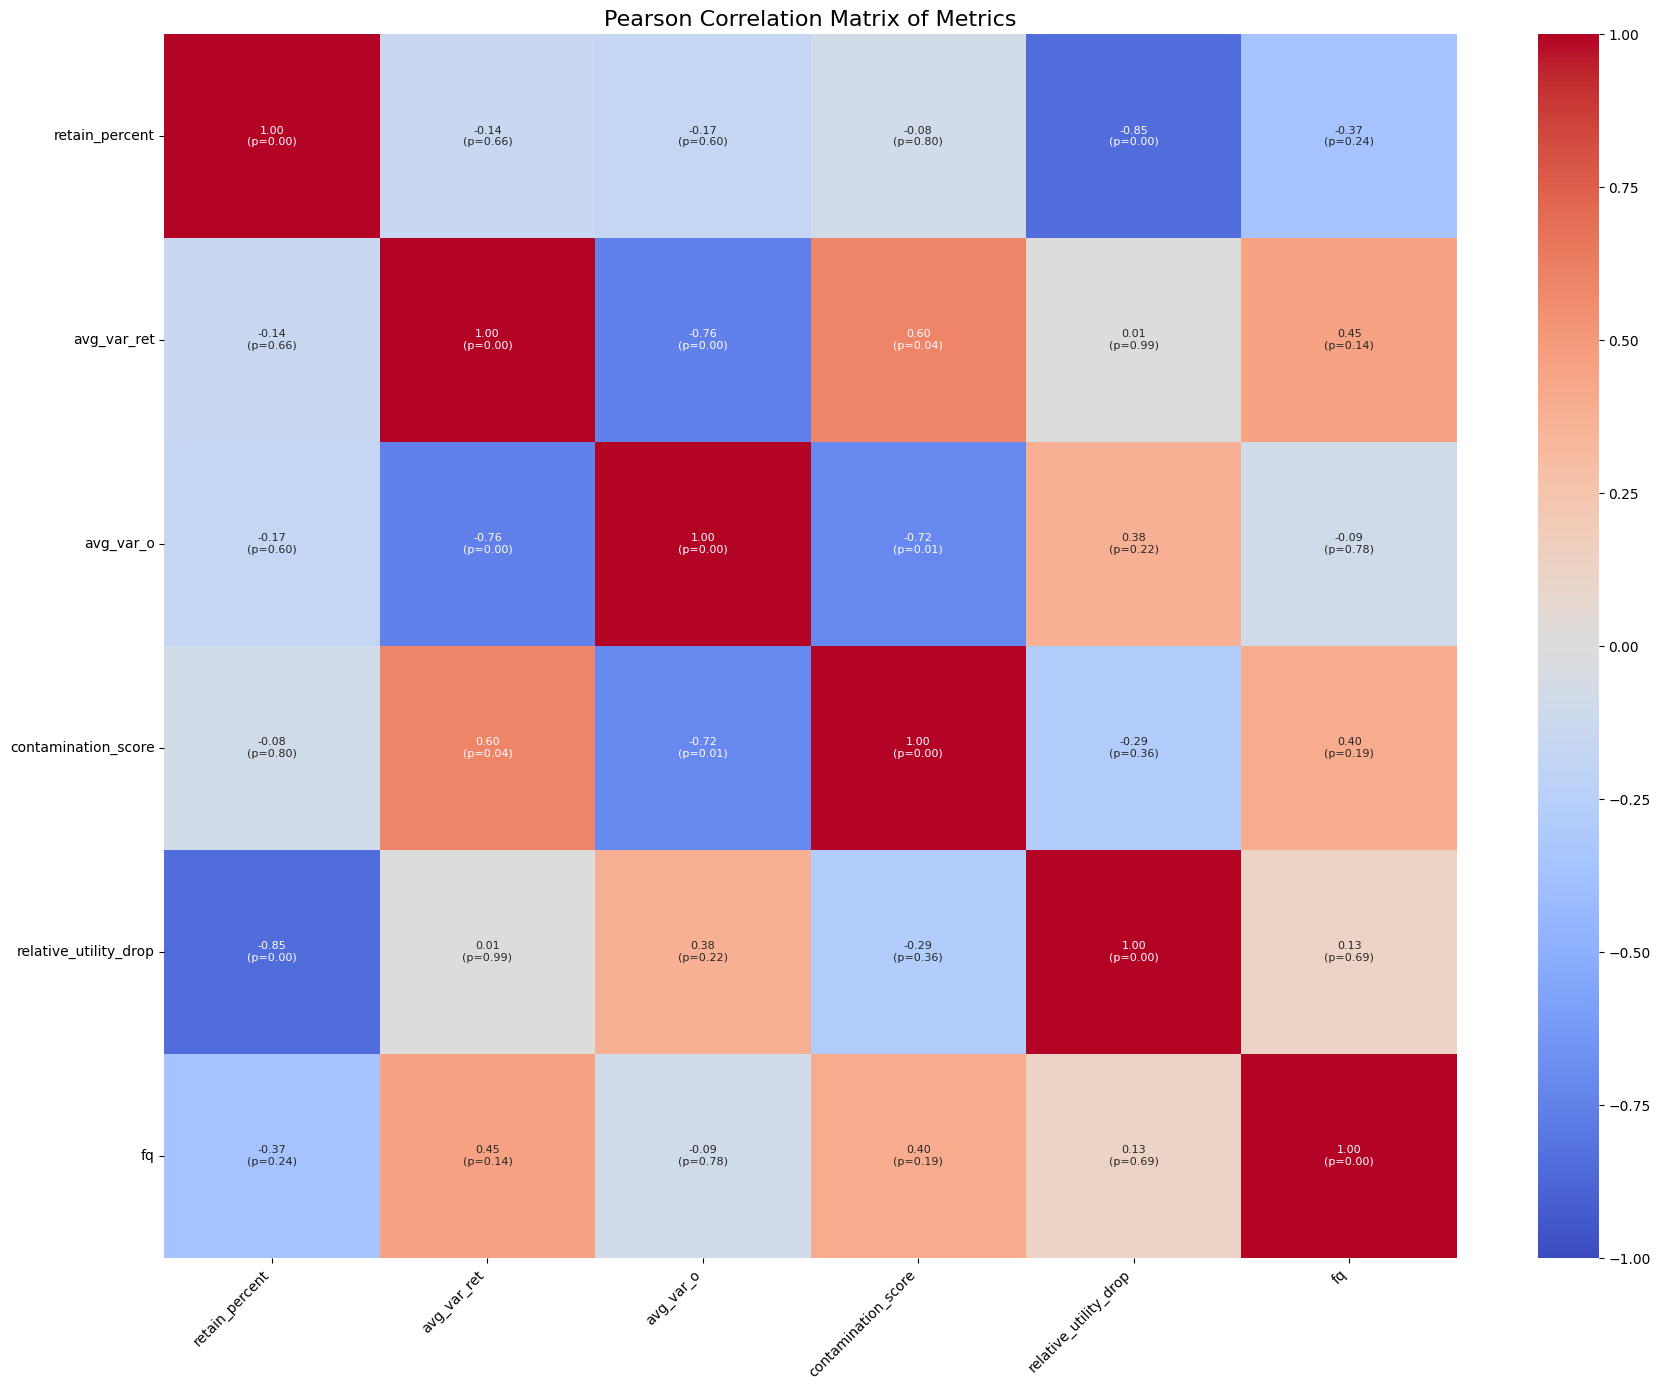

In [ ]:
pearson_annot = pearson_corr_matrix.map('{:.2f}'.format) + '\n(p=' + pearson_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(pearson_corr_matrix, annot=pearson_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Pearson Correlation Matrix of Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/pearson_wpu_semsyn.pdf', bbox_inches='tight')
plt.show()

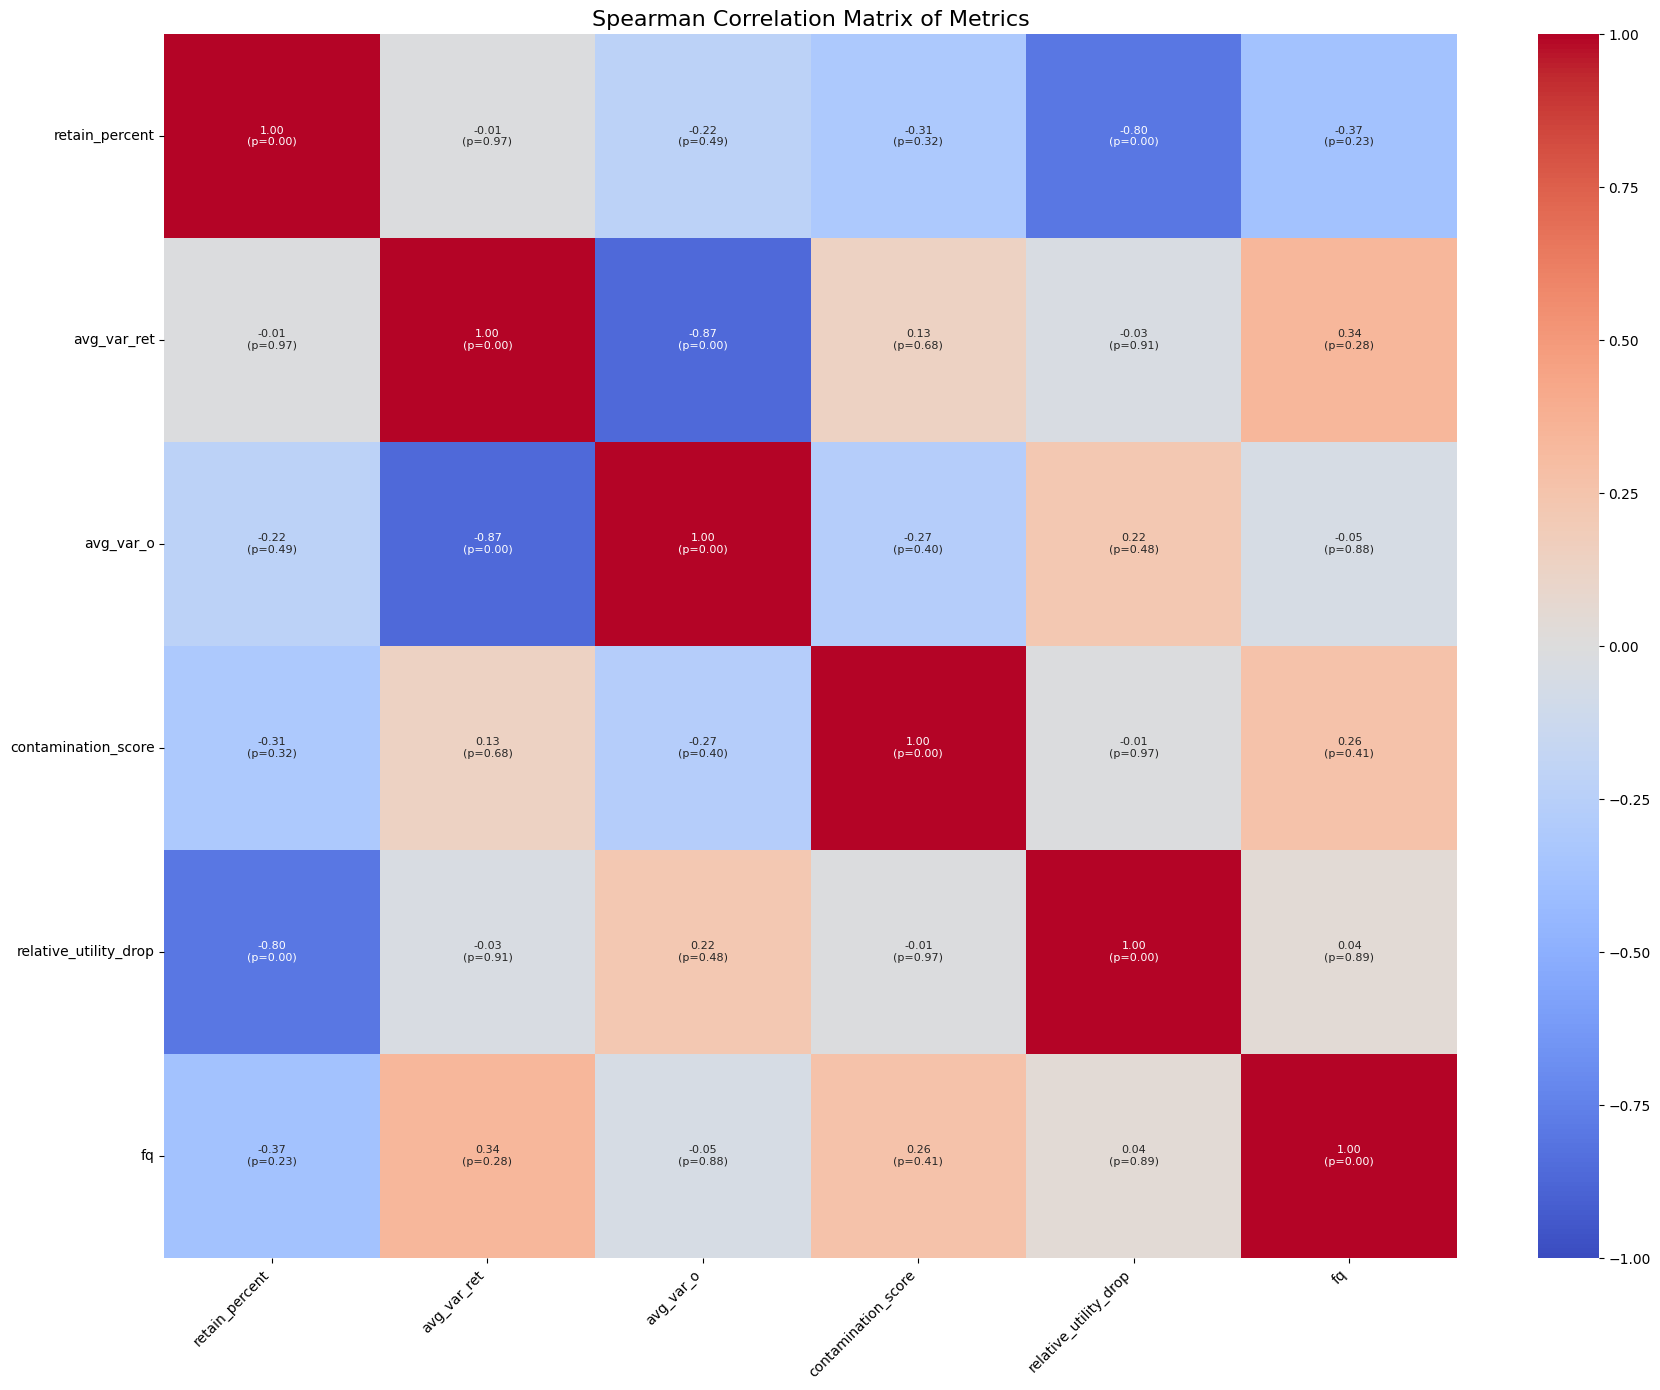

In [ ]:
spearman_annot = spearman_corr_matrix.map('{:.2f}'.format) + '\n(p=' + spearman_p_matrix.map('{:.2f}'.format) + ')'

plt.figure(figsize=(18, 14))
sns.heatmap(spearman_corr_matrix, annot=spearman_annot, fmt='s', cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 8})
plt.title('Spearman Correlation Matrix of Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./images/spearman_wpu_semsyn.pdf', bbox_inches='tight')
plt.show()

In [43]:
target_var = 'relative_utility_drop'

# Get the list of features to correlate with the target
features = cols_to_correlate.drop(target_var)

# Extract the correlation and p-values for the target variable
pearson_corrs = pearson_corr_matrix.loc[features, target_var]
pearson_ps = pearson_p_matrix.loc[features, target_var]
spearman_corrs = spearman_corr_matrix.loc[features, target_var]
spearman_ps = spearman_p_matrix.loc[features, target_var]

# Create a summary DataFrame
correlation_summary = pd.DataFrame({
    'Pearson Correlation': pearson_corrs,
    'Pearson p-value': pearson_ps,
    'Spearman Correlation': spearman_corrs,
    'Spearman p-value': spearman_ps
})

# Sort by the absolute value of Pearson correlation for better interpretation
correlation_summary['Abs Pearson Correlation'] = correlation_summary['Pearson Correlation'].abs()
correlation_summary = correlation_summary.sort_values(by='Abs Pearson Correlation', ascending=False).drop(columns=['Abs Pearson Correlation'])

# Display the formatted table
print(f"Correlations with '{target_var}':\n")
correlation_summary.style.format({
    'Pearson Correlation': '{:.3f}',
    'Pearson p-value': '{:.3f}',
    'Spearman Correlation': '{:.3f}',
    'Spearman p-value': '{:.3f}'
})

Correlations with 'relative_utility_drop':



,Pearson Correlation,Pearson p-value,Spearman Correlation,Spearman p-value
retain_percent,-0.847,0.001,-0.803,0.002
avg_var_o,0.381,0.222,0.224,0.484
contamination_score,-0.288,0.363,-0.014,0.966
fq,0.131,0.685,0.044,0.892
avg_var_ret,0.006,0.985,-0.035,0.914


#### cluster analysis

In [ ]:
EPS = 1e-12

In [ ]:
def make_pool_baseline(df_full, clusters):
    """Compute q_pool from the full dataset (fixed across experiments).
       Exclude 'forget' from the selectable pool baseline."""
    pool = df_full[df_full["type2"] != "forget_1"]
    pool_count = pool.groupby("cluster").size().reindex(clusters, fill_value=0)
    pool_total = int(pool_count.sum())
    q_pool = (pool_count / max(pool_total, 1)).astype(float)
    return pool_count, pool_total, q_pool

In [ ]:
def get_pref_ratio(df, method, q_pool, pool_count, pool_total, clusters, dataset,
                         mu_on="non_forget"):
    """
    df_exp is the experiment-specific df AFTER you assign type2 for (method, percent).
    Adds per-cluster FE, MU, and cluster-local variance terms alongside preference stats.
    """
    #df = get_df(df, ret_path)
    vc = df['type2'].value_counts(normalize=True)
    print(df['type2'].value_counts())
    forget_percent = _safe_percent(vc, 'forget_1')
    retain_percent = _safe_percent(vc, 'retain')
    # retain distribution
    retain_mask = (df["type2"] == "retain")
    retain_counts = (
        df.loc[retain_mask]
              .groupby("cluster")
              .size()
              .reindex(clusters, fill_value=0)
    )
    retain_total = int(retain_counts.sum())
    p_retain = (retain_counts / max(retain_total, 1)).astype(float)

    # preference & log2
    pref_ratio = (p_retain.values + EPS) / (q_pool.values + EPS)
    pref_log2 = np.log2(pref_ratio)


    rows = []
    label = f"{method} | {retain_percent}%"

    for idx, c in enumerate(clusters):
        df_c = df[df["cluster"] == c]
        #avg_var_ret, avg_var_f, avg_var_o, avg_var_full = get_variance(df_c)
        rows.append({
            "method": method,
            "dataset": dataset,
            "retain_pct": int(retain_percent),
            "label": label,
            "cluster": int(c),

            "retain_count": int(retain_counts.values[idx]),
            "retain_total": int(retain_total),
            "p_retain": float(p_retain.values[idx]),
            "pool_count": int(pool_count.values[idx]),
            "pool_total": int(pool_total),
            "q_pool": float(q_pool.values[idx]),
            "pref_ratio": float(pref_ratio[idx]),
            "pref_log2": float(pref_log2[idx]),

            })
    return pd.DataFrame(rows)

In [ ]:
clusters = list(range(10))  # 0..9
df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_20.csv")
pool_count, pool_total, q_pool = make_pool_baseline(df, clusters)
pool_count, pool_total, q_pool

/home/praveen/tmp/ipykernel_973904/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):


(cluster
 0    272
 1    167
 2    240
 3    174
 4    303
 5    226
 6    285
 7    289
 8    167
 9    169
 dtype: int64,
 2292,
 cluster
 0    0.118674
 1    0.072862
 2    0.104712
 3    0.075916
 4    0.132199
 5    0.098604
 6    0.124346
 7    0.126091
 8    0.072862
 9    0.073735
 dtype: float64)

In [28]:
def extract_user_query(text):
    match = re.search(r"<\|start_header_id\|>user<\|end_header_id\|>(.*?)<\|eot_id\|><\|start_header_id\|>assistant", text, re.S)
    if match:
        return match.group(1).strip()
    return text

def get_res(df, res_path):
    res = pd.read_csv(res_path)
    cols = ['truth', 'probs', 'cos_sims', 'rouge_l']
    cols_to_drop = [col for col in cols if col in df.columns]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, axis=1, inplace=True)
    res["question"] = res["question"].apply(extract_user_query)
    res['question'] = res['question'].str.lower()
    res['answer'] = res['answer'].str.lower()
    res['title'] = res['title'].str.lower()
    df['question'] = df['question'].str.lower()
    df['answer'] = df['answer'].str.lower()
    df['title'] = df['title'].str.lower()
    df  = df.merge(
        res[["title", "question", "answer",  "truth", "probs", "cos_sims", "rouge_l"]],
        on=["title", "question", "answer",],
        how="left")

    return df


In [ ]:
results = []

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_5.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_20.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_difference/diff_20.csv")
results.append(
    get_pref_ratio(df, method="grand(diff)_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_5.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_20.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/grand/grad_descent/desc_20.csv")
results.append(
    get_pref_ratio(df, method="grand(CE)_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/moderate/mod_5.csv")
results.append(
    get_pref_ratio(df, method="moderate_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/moderate/mod_20.csv")
results.append(
    get_pref_ratio(df, method="moderate_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/moderate/mod_20.csv")
results.append(
    get_pref_ratio(df, method="moderate_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/random/random_5.csv")
results.append(
    get_pref_ratio(df, method="random_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/random/random_10.csv")
results.append(
    get_pref_ratio(df, method="random_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/random/random_20.csv")
results.append(
    get_pref_ratio(df, method="random_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/semantic/semantic_5.csv")
results.append(
    get_pref_ratio(df, method="semantic_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/semantic/semantic_10.csv")
results.append(
    get_pref_ratio(df, method="semantic_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/semantic/semantic_20.csv")
results.append(
    get_pref_ratio(df, method="semantic_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/syntactic/syntactic_5.csv")
results.append(
    get_pref_ratio(df, method="syntactic_5",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/syntactic/syntactic_10.csv")
results.append(
    get_pref_ratio(df, method="syntactic_10",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

df = get_df(df, ret_path="./data/wpu_data/coresets/syntactic/syntactic_20.csv")
results.append(
    get_pref_ratio(df, method="syntactic_20",
                         q_pool=q_pool, pool_count=pool_count, pool_total=pool_total,
                         clusters=clusters, dataset = 'unified')
)

results_df = pd.concat(results, ignore_index=True)

/home/praveen/tmp/ipykernel_973904/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_973904/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_973904/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df["type2"]):
/home/praveen/tmp/ipykernel_973904/1008262423.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

The heatmap shows pref_log2, neutral(0) is white, red = overselected, blue= underselected

- p_retain = retain cluster share (retain_count / retain_total)
- pool_count - # selectable (non - forget) samples in this cluster
- pool_total - Total selectable (non-forget) samples across all clusters
- q_pool - pool cluster share = pool_count/pool_total
- pref_ratio - p_retain/q_pool 
- pref_log2 - logarithm value of pref_ratio 


<Axes: xlabel='method', ylabel='cluster'>

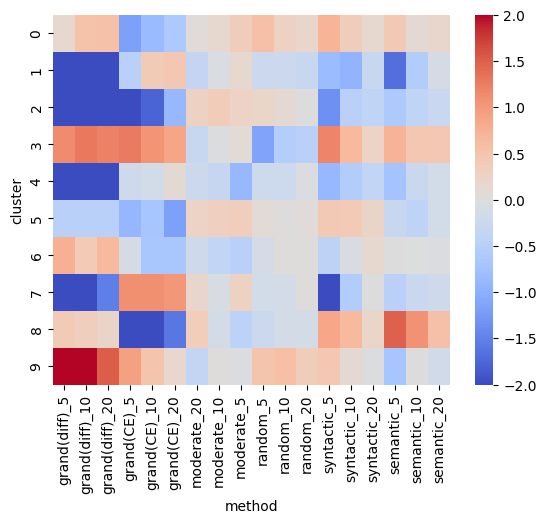

In [ ]:
heat = results_df.pivot(index="cluster", columns="method", values="pref_log2")

method_order = ["Random","Moderate","Grand(desc)","Grand(diff)"]
col_order = (results_df[["method"]]
             .drop_duplicates()
             .sort_values(by=["method"], key=lambda s: s.map(
                 {m:i for i,m in enumerate(method_order)} if s.name=="method" else s))
             ["method"].tolist())
heat = heat.reindex(columns=col_order)
ax = sns.heatmap(heat, center=0.0, cmap="coolwarm", vmin=-2, vmax=2)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("./images/wpu_pref_log2.pdf", bbox_inches="tight")
plt.close(fig)